## Graph Based Algorithms

- author: Lei (Nico) Zheng 
- email: lzheng9[at]stevens.edu

You can also access the content of this notebook in my github:

http://nbviewer.jupyter.org/github/Nicozheng/teaching_network/blob/master/GraphBasedAlgorithms.ipynb

**Requirement**
- simplejson
- gensim
- sklearn

please use <code>pip</code> or <code>conda</code> to install these packages. For example:

    sudo pip install gensim
    
for conda users:

    conda install gensim


## Graph as a Framework

In the above notebook, we find that Graph can be used as a general framework to summarize and analyze real-world problems. There are also a lot famous graph based algorithms, for example:

#### PageRank/TextRank Algorithm
paper: [The anatomy of a large-scale hypertextual web search engine (Brin and Page, 1998)](http://ilpubs.stanford.edu:8090/361/1/1998-8.pdf)

<img src="http://yifanhu.net/GIF/www.gif" width="30%" align="center">

### Graph based Recommendation System 

<img src="https://jiashuang.files.wordpress.com/2015/11/cac0522b58a3a902c098e590688282971.jpg" width="40%">

### Probabilistic Graph Model
#### A basic Bayesian Network

<img src="https://cdn-images-1.medium.com/max/1600/1*9OsQV0PqM2juaOtGqoRISw.jpeg" width="40%">

#### A network measure human anatomical connections

paper: [A Weighted Stochastic Block Models of the Human Connectome across the Life Span](https://www.nature.com/articles/s41598-018-31202-1)

<img src="https://media.springernature.com/lw900/springer-static/image/art%3A10.1038%2Fs41598-018-31202-1/MediaObjects/41598_2018_31202_Fig1_HTML.png" width="50%">

In this notebook, we will first talk about Google's famous PageRank algorithm, then explore its replication in NLP area ([TextRank](http://www.aclweb.org/anthology/W04-3252) for text extraction), finally, generate an Industry network based on company's 10K annual report. 

### PageRank Theory
First, let's check the theory of PageRank in this [video](https://www.youtube.com/watch?v=P8Kt6Abq_rM)

From above video, we know that the basic idea implemented by a graph-based ranking model is that of **“voting”** or “recommendation”. When one node links to another one, it is basically casting a vote for that other node. The higher the number of votes that are cast for a node, the higher the importance of the node. Moreover, the importance of the node casting the vote determines how important the vote itself is, and this information is also taken into account by the ranking model.

Hence the score or importance of a node can be represent as:

<img src="https://github.com/Nicozheng/teaching_network/blob/master/formula.png?raw=true" width="30%">

where 
- $d$ is a damping factor, usually set to 0.85;
- $In(V_i)$ is the set of nodes that point to node i
- $Out(V_i)$ is the set of nodes that node i point to

Now, let's build this algorithm in python from scratch and apply it to a text network. (This method also called TextRank, paper can be found [here](http://www.aclweb.org/anthology/W04-3252))

### Implement PageRank From Scratch

- Our target is to get the most important words (top N) from a piece of text using PageRank algorithm. 

In [1]:
import pandas as pd 
import numpy as np 
import simplejson as sjson
import networkx as nx 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from itertools import combinations
import re
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

In [2]:
text = '''
In mathematics, graph theory is the study of graphs, which are mathematical structures used to model pairwise relations between objects. 
A graph in this context is made up of vertices, nodes, or points which are connected by edges, arcs, or lines. A graph may be undirected, meaning that there is no distinction between 
the two vertices associated with each edge, or its edges may be directed from one vertex to another; see Graph (discrete mathematics) for more detailed definitions and for other variations 
in the types of graph that are commonly considered. Graphs are one of the prime objects of study in discrete mathematics.
'''

In [3]:
def build_nextwork(text, split=10, threshold=2):
    '''
    build undirected text network based on input string.
    edges is the words co-mention relationship, where build an edge between A and B if their comention >= threshold. 
    '''
    ## preprocessing, remove all punctuations
    text = re.sub("[^a-zA-Z]", " ", text)  # replace characters that are not a-z A-Z
    text = re.sub(" +", " ", text) # replace multiple spaces into one 
    text = text.lower().split(" ")  # split text into words
    words = set(text) - ENGLISH_STOP_WORDS - set([''])   # remove stopwords, words is all the words remain in the input text
    subsentences = []  # store sentences
    for i in range(len(text)):
        subsentences.append(text[i:i+split])  # generate subsentences based on split number, each subsentences will contain 10 words
    nodes = []   # list store network nodes 
    for i,j in combinations(words,2):  # for every possible word combinations
        cnt = 0
        for subsentence in subsentences:
            if (i in subsentence) and (j in subsentence):
                cnt+=1   # count comention of i and j in subsentences
        if cnt >= threshold:  # add i and j as nodes if comention number meet threshould
            nodes.append((i,j))
    ## generate network 
    G = nx.Graph()
    G.add_edges_from(nodes)  # creat graph 
    return G

In [4]:
G = build_nextwork(text)

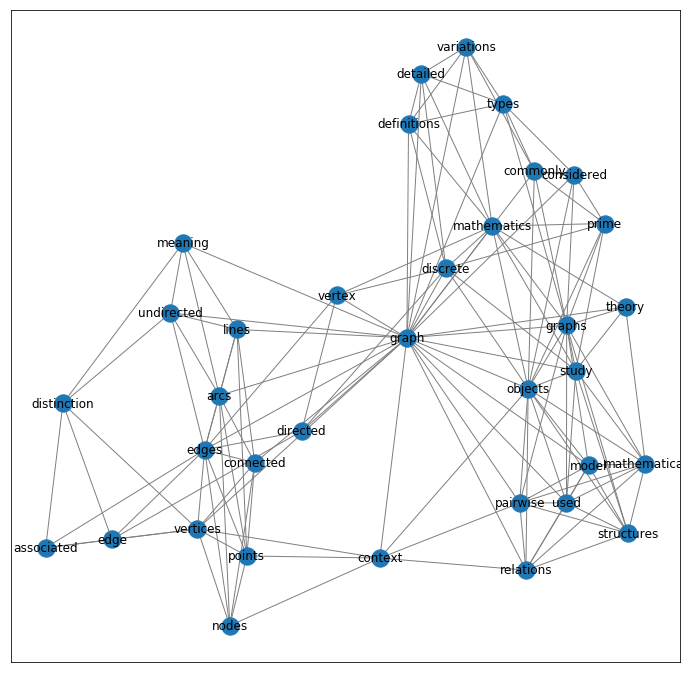

In [5]:
plt.figure(figsize=(12,12))
nx.draw_networkx(G, edge_color="0.5")

In [6]:
class GraphBasedRanking:  
    '''
    implement Google's PageRank, also called TextRank algorithm in NLP area.
    '''
    def __init__(self, graph, damping_factor=0.85, iterations=100, eta=0.0001):  # initialize model
        self.graph = graph
        self.damping_factor = damping_factor
        self.iterations = iterations   ## maximum iterations
        self.eta = eta  ## error rate, stop if the node importance error rate (last iteration - current iteration) is less than this value
        self.nodes = list(self.graph.nodes)   ## total nodes in a graph 
        nodes_num = len(self.nodes) 
        self.score = dict(zip(self.nodes, [1/nodes_num]*nodes_num))  ## initialize node importance into 1/N
    
    def fit(self):
        for i in range(self.iterations):
            last_score = np.array(list(self.score.values())).copy()   ## store node importance from last iteration
            for node in self.nodes:
                neighbors = list(self.graph.neighbors(node))   ## get nodes pointing to this nodes
                tmp = sum([(1/len(list(self.graph.neighbors(c))))*self.score[c] for c in neighbors])   # get weighted sum of node's neighbors importance 
                self.score[node] = (1-self.damping_factor) + self.damping_factor*tmp   ## update node importance
            convergence = np.mean(np.abs(last_score - np.array(list(self.score.values()))))  ## check error rate
            if convergence <= self.eta:  # stop if convergence 
                break
                
    def summarize(self, component_num = 5):
        rank = sorted(self.score.items(), key=lambda x:x[1], reverse=True)  ## sort nodes based on their importance 
        return [c[0] for c in rank[:component_num]]  # extract N components with largest score

In [7]:
## test model
test = GraphBasedRanking(G)
test.fit()
test.summarize(10)

['graph',
 'objects',
 'graphs',
 'edges',
 'mathematics',
 'vertices',
 'study',
 'discrete',
 'arcs',
 'mathematical']

Well, you can also access this algorithm easily in networkx by calling <code>nx.pagerank</code>. 

In [8]:
pd.Series(nx.pagerank(G)).sort_values(ascending=False)[:10]   # pagerank in networkx

graph           0.083170
objects         0.046830
graphs          0.044126
edges           0.043804
mathematics     0.036693
vertices        0.034012
study           0.032410
discrete        0.031109
arcs            0.029849
mathematical    0.029343
dtype: float64

People have made various improvement to make it suitable for NLP work, and TextRank has been embedded into **gensim**, please find it [here](https://radimrehurek.com/gensim/summarization/keywords.html). 

In [9]:
from gensim.summarization import keywords

In [10]:
keywords(text).split("\n")   # textrank in gensim

['graphs', 'mathematics graph', 'pairwise', 'vertices', 'mathematical']

### Application: A Text-Based Industry Network

Well, network model can also be used to represent company relationship. Similar companies are more likely to have more similar financial pattern (for example, coherence in the stock market performance); or more likely to influence by the same external shock (for example, recent stock crash is caused by high-tech companies); or more likely to have mergers and acquisitions. 

Now, let's try to build a Text-based industry network based on companies' 10-K annual report. This implementation mimic a [study](http://faculty.tuck.dartmouth.edu/images/uploads/faculty/gordon-phillips/FinalJPE.pdf) by (Hoberg and Phillips, 2016)

### Four Steps to Build a Text-Based Industry Network

1. Extract Keywords from firm 10K;
2. Build a Bag-of-Words representation. 
3. Estimate Firm Cosine Similarity.
4. Apply a threshold and build Network. 

In [11]:
# load data first
def read_data(file_path):
    data = [] 
    with open(file_path) as f:
        for line in f:
            tmp = sjson.loads(line)    # load documents
            data.append((tmp['gvkey'],tmp['comp_name'],tmp['item_1']))
    data = pd.DataFrame(data)  # transform the document into pandas dataframe
    data.columns = ['gvkey','comp_name','doc']
    return data

data = read_data("data/sample_data 2.txt")

In [12]:
data.head()

,gvkey,comp_name,doc
0,5252,GRACO INC,Item 1. Business Graco Inc. together with its ...
1,121759,ID SYSTEMS INC,Item 1. Business Overview I.D. Systems Inc. wa...
2,5600,HERTZ CORP,ITEM 1. BUSINESS OUR COMPANY We operate our ca...
3,5018,GENCORP INC,Item 1. Business Unless otherwise indicated or...
4,5284,GRAY TELEVISION INC,Item 1. Business. In this annual report on For...


In [13]:
len(data)   # the sample data contains 1000 firm's 10K in 2014

1000

#### 1. Extract Keywords 

In [14]:
def extract_keywords(text_list):
    extracted = []
    for text in text_list:
        extracted += keywords(text).split("\n")
    return set(extracted)  # save the keywords as set to save memory space

In [15]:
%time extracted = extract_keywords(data['doc'][:10])

CPU times: user 8.51 s, sys: 451 ms, total: 8.97 s
Wall time: 6.87 s


In [16]:
list(extracted)[:20]   # extracted keywords

['financial information',
 'airports',
 'negotiating',
 'impacting',
 'awards',
 'patent',
 'fireplace',
 'protections',
 'continued',
 'affecting',
 'design',
 'metv',
 'foreign marine assets',
 'purchase',
 'order',
 'failures',
 'ended',
 'rankings',
 'provide',
 'competitive']

Well, becuase the extraction of 1000 documents could be time consuming, we will use pre-extracted words here.

In [17]:
with open("data/10k_nouns_20171029.pickle", 'rb') as f:
    nouns = pickle.load(f)

#### 2. Build a Bag-of-Words representation

<img src="https://github.com/Nicozheng/teaching_network/blob/master/bag_of_words.jpg?raw=true" width="50%">

In [18]:
# use sklearn CountVector to build BOW model 
vect = CountVectorizer(vocabulary=nouns,   # use predefined words bag
                       lowercase=True,    
                       stop_words='english',  # standard english stopwords
                       binary=True).fit(data['doc'])  # binary count
vect_matrix = vect.transform(data['doc']).toarray()

In [19]:
vect_matrix  # the returned vect matrix 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
np.shape(vect_matrix), len(data), len(nouns)  # the returned BOW matrix will have a shape according to the input 

((1000, 23526), 1000, 23526)

Text(0, 0.5, 'Probability')

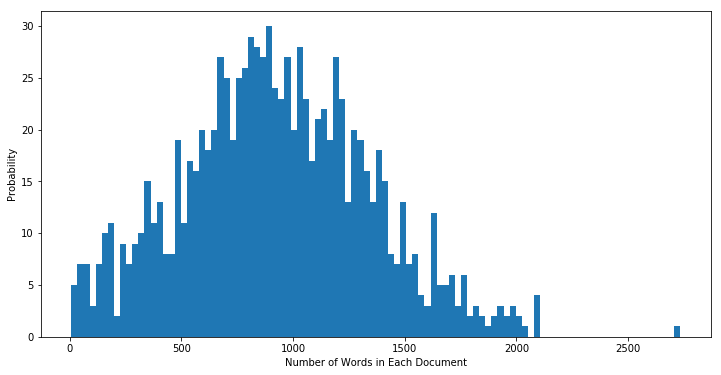

In [21]:
doc_use_words = np.sum(vect_matrix, axis=1)  # count each firm use how many words 
plt.figure(figsize=(12,6))
plt.hist(doc_use_words, bins=100)
plt.xlabel('Number of Words in Each Document')
plt.ylabel('Probability')

#### 3. Calculate Firm cosine similarity 

**Cosine Similarity** is a widely used measurement of document similarity in NLP area.
It measures the cosine of the angle between two non-zero vectors.

<img src="http://blog.christianperone.com/wp-content/uploads/2013/09/Dot_Product.png">

The formula is:

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTM0qRJEB0XHmvkrc7mMMIKS9lXH6stFImsHhIVLrFaLE4CHgKD0Q">

we can calculate it use <code>cosine_similarity</code> in <code>sklearn.metrics.pairwise</code>

In [22]:
similarity = cosine_similarity(vect_matrix)  # calculate cosine similarity 
np.shape(similarity) # firm pair-wise cosine similarity matrix 

(1000, 1000)

Text(0, 0.5, 'Probability')

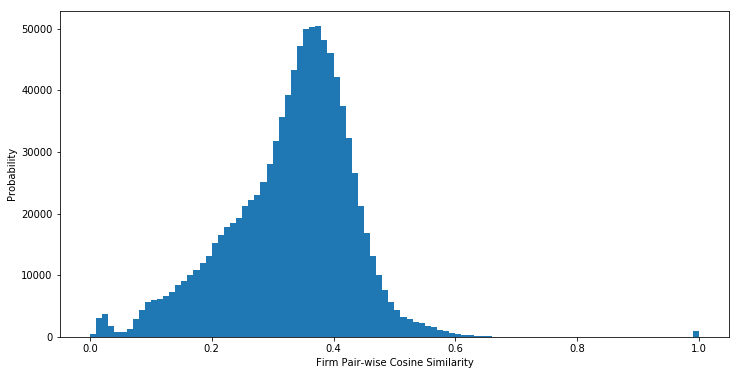

In [23]:
plt.figure(figsize=(12,6))
plt.hist(similarity.flatten(), bins=100)
plt.xlabel('Firm Pair-wise Cosine Similarity')
plt.ylabel('Probability')

#### 4. Apply threshold and Build Network

In [30]:
def build_industry_network(similarity_matrix, company_names, threshold=0.55):
    similarity_matrix = np.where(similarity_matrix>threshold, similarity_matrix, 0)  # set cosine similarity to 0 if it is smaller than the threshold
    # change the diagonal value into 0 
    for i in range(len(similarity_matrix)):
        similarity_matrix[i,i] = 0
    G = nx.from_numpy_matrix(similarity_matrix, create_using=nx.Graph()) # creating from adjacency matrix 
    node_name = dict(zip(range(0,len(list(G.nodes()))),company_names))  
    G = nx.relabel_nodes(G, node_name)  # change node name to company name 
    return G

In [31]:
industry_network = build_industry_network(similarity, data['comp_name'].values)

In [32]:
len(industry_network.edges)

3785

now let's check with a financial company, see what kind of "related firms" it has

In [33]:
def select_industry(industry_network, focal_firm):
    companies = set(industry_network.neighbors(focal_firm)) | set([focal_firm])
    return companies

In [34]:
selected_firm_name = "LINKEDIN CORP"
related_firms = select_industry(industry_network, selected_firm_name)
print("related firms to %s are: " %selected_firm_name)
print(related_firms)
subgraph = nx.subgraph(industry_network, related_firms)

related firms to LINKEDIN CORP are: 
{'Five9 Inc.', 'MARIN SOFTWARE INC', 'Palo Alto Networks Inc', ' Apigee Corp', 'CHEGG INC', 'VARONIS SYSTEMS INC', 'Upland Software Inc.', 'MARCHEX INC', 'LINKEDIN CORP', 'REALPAGE INC', 'RingCentral Inc', 'DEMAND MEDIA INC.', 'Google Inc.', 'TrueCar Inc.', 'Facebook Inc', 'LIFELOCK INC.', 'Workday Inc.'}


The result seems pretty accurate since all related firms are finacial agencies. You can of course extend this model by integrating more financial information. 
Now, let's visualize the forcal company and its related firms! 

In [35]:
def plot_industry(G):
    plt.figure(figsize=(15,15))
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, node_size=800, font_size =18, edge_color='0.5', pos=pos, cmap=plt.cm.Reds)

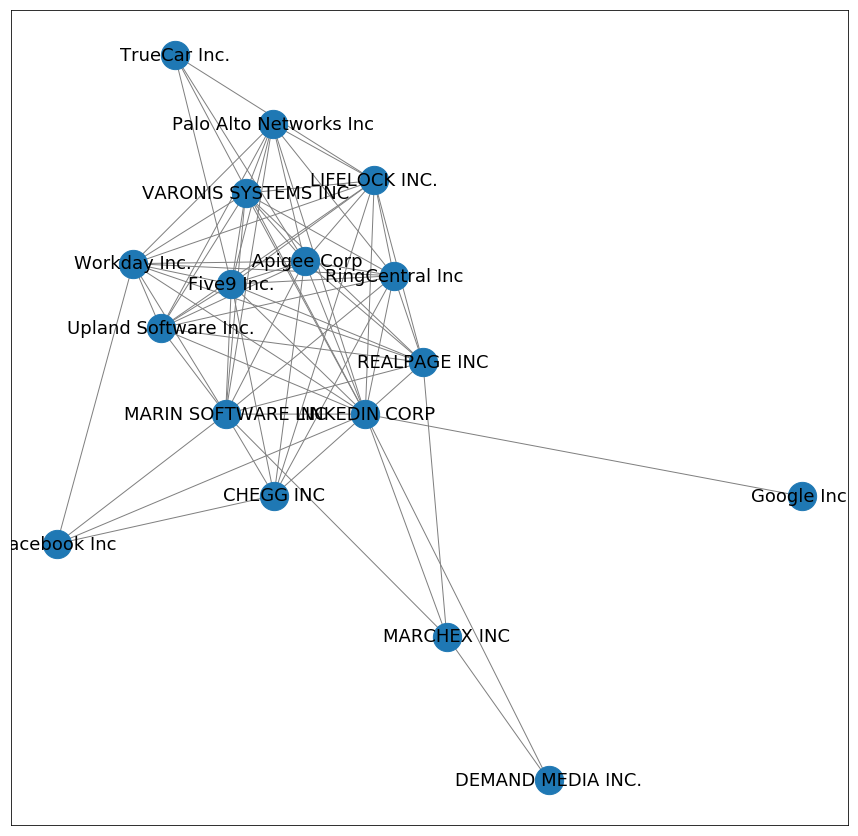

In [36]:
plot_industry(subgraph)

## Practice

Considering each firm and its neighbors as a sub-industry, please answner following questions:

In [37]:
## load accounting data
accounting_data = pd.read_csv("data/tbni_financial_data.csv")
accounting_data.head()

,gvkey,comp_name,mkvalt,profitability,sales_growth
0,1004,AAR CORP,1046.3954,0.052500,-0.216560
1,1045,American Airlines Group Inc.,37405.5843,0.154396,0.596661
2,1050,CECO ENVIRONMENTAL CORP,408.1892,0.135250,0.333980
3,1078,ABBOTT LABORATORIES,67891.7357,0.221020,-0.073279
4,1094,ACETO CORP,521.9241,0.108997,0.020991


In [38]:
accounting_data.apply(lambda x: sum(pd.isnull(x)))

gvkey             0
comp_name         0
mkvalt           33
profitability     0
sales_growth      0
dtype: int64

### Which industry grows fastest?

In [39]:
average_sales_growth = {}
for firm in accounting_data['comp_name']:
    industry = select_industry(industry_network, firm)
    mask = accounting_data['comp_name'].apply(lambda x: x in industry)
    tmp = accounting_data[mask]
    average_sales_growth[firm] = np.mean(tmp['sales_growth'])

In [40]:
pd.Series(average_sales_growth).sort_values(ascending=False)[:5]

BioRestorative Therapies Inc.    207.000000
Imprimis Pharmaceuticals Inc.    165.000000
DAKOTA PLAINS HOLDINGS INC.       80.034384
DISCOVERY LABORATORIES INC DE      6.306701
CombiMatrix Corp                   5.050457
dtype: float64

### Which industry has the largest market value?

- please notice that mkvalt in accounting data has missing values, use the average market value of related firms to fill in the missing value. If the company do not have related firm, using 6134 (average mkvalt of all firms) to replace it. 

### On the one hand, having a lot of competitors may indicate that the company is in a well-deleloped, profitable industry. On the other hand, having too many competitors will reduce the profitability of a company (the industry is close to a perfectly competitive market). So, what's the relationship between the number of competitors and a company's profitability?

- Hint: this is an emprical question, use a **regression** (OLS is suitable) to validate your hypothesis. 

- you may want to install statsmodels

```shell
pip install -U statsmodels
```

https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html